In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/test.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv


In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

In [31]:
from subprocess import check_output
print(check_output(["ls", "../input/quora-question-pairs"]).decode("utf8"))

sample_submission.csv.zip
test.csv
test.csv.zip
train.csv.zip



In [32]:
import zipfile

Dataset = "train.csv"

# Will unzip the files so that you can see them..
with zipfile.ZipFile("../input/quora-question-pairs/"+Dataset+".zip","r") as z:
    z.extractall(".")

In [33]:
from subprocess import check_output
print(check_output(["ls", "train.csv"]).decode("utf8"))

train.csv



In [34]:
df = pd.read_csv('train.csv')

In [35]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [36]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [37]:
df.isnull().any()

id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

In [38]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [39]:
df = df.dropna(how='any',axis=0)

In [40]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404287.000000,404287.000000,404287.000000,404287.000000
mean,202144.340337,217243.151093,220955.212082,0.369201
std,116708.673691,157751.614317,159903.168488,0.482589
min,0.000000,1.000000,2.000000,0.000000
25%,101071.500000,74436.500000,74726.500000,0.000000
50%,202145.000000,192181.000000,197053.000000,0.000000
75%,303216.500000,346573.000000,354692.000000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [41]:
df.isnull().any()

id              False
qid1            False
qid2            False
question1       False
question2       False
is_duplicate    False
dtype: bool

In [42]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

># Analysis by ids

Total number of question pairs for training: 404287
Duplicate pairs: 36.92%
Total number of unique questions in the training data: 537929
Number of questions that appear multiple times: 111778



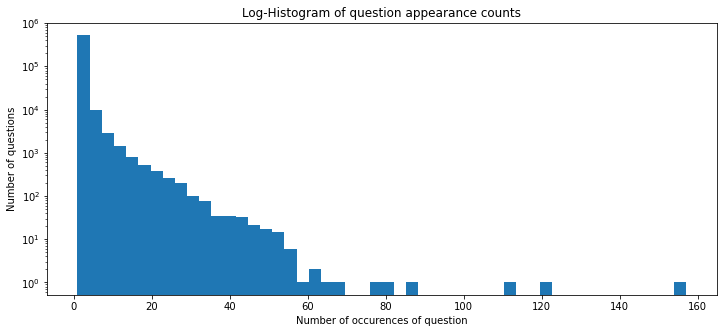

In [44]:
print('Total number of question pairs for training: {}'.format(len(df)))
print('Duplicate pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Total number of unique questions in the training data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [45]:
X = df[['question1', 'question2']]
y = df['is_duplicate']

In [46]:
X.head()

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


>#  Count max no. of words in the question1,2 column

In [47]:
(X['question1'].str.count(' ')+1).max()

125

In [48]:
(X['question2'].str.count(' ')+1).max()

237

In [54]:
(X['question2'].str.count(' ')+1).mode()

0    8
dtype: int64

In [51]:
(X['question1'].str.count(' ')+1).mode()

0    8
dtype: int64

> # Plotting count plots 

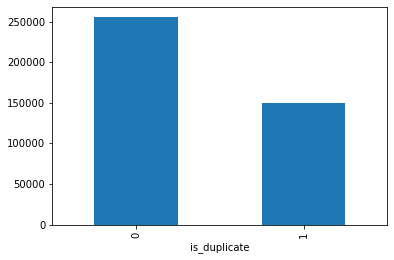

In [55]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [56]:
df['qids']=qids

>#   It is not an imbalanced dataset, but we might tune the class-weight parameter.

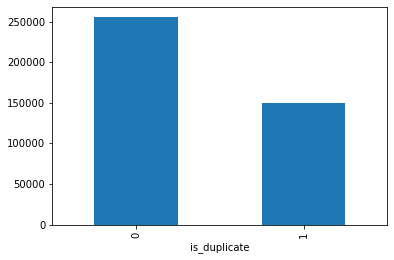

In [57]:
df.groupby("is_duplicate")['qids'].count().plot.bar()

> Printing the questions to write a cleaning code

In [60]:
a=0
for i in range(a,a+20):
    print(df.question1[i])
    print(df.question2[i])
    print(df.is_duplicate[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?
0

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
0

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?
0

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?
0

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?
0

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
1

Should I buy tiago?
What keeps childern active and far from phone and video games?
0

How can I be a good geologist?
What should I do to be a great geologist?
1

When do 

In [61]:

SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

#    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
#     # all numbers should separate from words, this is too aggressive
    
#     def pad_number(pattern):
#         matched_string = pattern.group(0)
#         return pad_str(matched_string)
#     text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
#    def pad_pattern(pattern):
#        matched_string = pattern.group(0)
#       return pad_str(matched_string)
#    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # indian dollar
    
    text = re.sub("(?<=[0-9])rs ", " rupees ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rupees ", text, flags=re.IGNORECASE)
    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text
    
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

In [63]:
a=0
for i in range(a,a+20):
    print(df.question1[i])
    print(df.question2[i])
    print()

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market

what is the story of kohinoor kohinoor diamond
what would happen if the indian government stole the kohinoor kohinoor diamond back

how can i increase the speed of my internet connection while using a vpn
how can internet speed be increased by hacking through dns

why am i mentally very lonely how can i solve it
find the remainder when math2324math is divided by 2423

which one dissolve in water quikly sugar salt methane and carbon di oxide
which fish would survive in salt water

astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
i am a triple capricorn sun moon and ascendant in capricorn what does this say about me

should i buy tiago
what keeps childern active and far from phone and video games

how can i be a good geologist
what should i do to be a great geologist

when do you use  nonasciiword  instead of  nonasciiword 
when do y

In [78]:
X = df[['question1','question2']]

> We will be using word2vec pre-trained Google News corpus. We load these into a Gensim Word2Vec model class.



In [65]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

In [79]:
from nltk.corpus import stopwords


In [70]:
import gensim
from gensim.models import Word2Vec
    
model = wv

In [80]:
question1 = 'What would a Trump presidency mean for current international master’s students on an F1 visa?'
question2 = 'How will a Trump presidency affect the students presently in US or planning to study in US?'
stopwords = stopwords.words('english')

question1 = question1.lower().split()
question2 = question2.lower().split()

question1 = [w for w in question1 if w not in stopwords]
question2 = [w for w in question2 if w not in stopwords]

># Word mover's distance is a method that allows us to assess the distance beteen 2 documents in a meaningful way no matter thay have or have no words in common.It uses Euclidean distance therefore normalizing them is important.

In [81]:
model.init_sims(replace=True)
distance = model.wmdistance(question1, question2)
print('normalized distance = %.4f' % distance)

normalized distance = 0.7589


In [114]:
x = "Method to find separation of slits using fresnel biprism?"
y = "What are some of the things technicians can tell about the durability and reliability of Laptops and its components"
x= x.split()
y=y.split()
x = [w for w in x if w not in stopwords]
y = [w for w in y if w not in stopwords]

In [115]:
distance = model.wmdistance(x, y)
print('normalized distance = %.4f' % distance)

normalized distance = 1.2745


In [89]:
a = "My name is Riya Jain"
b = "My name  Riya Jain"
a = [w for w in a if w not in stopwords]
b = [w for w in b if w not in stopwords]
distance = model.wmdistance(a, b)
print('normalized distance = %.4f' % distance)

normalized distance = 0.0000


In [90]:
X.head()

,question1,question2
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water


> # Making Features using different techniques

># 1. Length of the question (counting every letter including space).

In [93]:
X['q1_len']=X.question1.apply(lambda x:len(str(x)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
X['q2_len']=X.question2.apply(lambda x:len(str(x)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [95]:
X.head()

,question1,question2,q1_len,q2_len
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,46,83
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,72,58
3,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,48,55
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,73,38


In [96]:
X['q1_len'].max()

601

In [97]:
X['q2_len'].max()

1137

> # 2. The difference in the count of letters between q1 and q2.

In [98]:
X['len_diff'] = abs(X['q1_len']-X['q2_len'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [99]:
X.head()

,question1,question2,q1_len,q2_len,len_diff
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56,9
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,46,83,37
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,72,58,14
3,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,48,55,7
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,73,38,35


> # Using fuzzywuzzy to create multiple feature columns as this library is used for string matching.

In [100]:
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
X['fuzzywuzzy_ratio'] = X.apply(lambda x:fuzz.ratio(str(X['question1']),str(X['question2'])),axis=1)

KeyboardInterrupt: 

In [ ]:
X['fuzzywuzzy_token_set_ratio'] = X.apply(lambda x:fuzz.token_set_ratio(str(X['question1']),str(X['question2'])),axis=1)

In [ ]:
X['fuzz_partial_ratio'] = X.apply(lambda x:fuzz.partial_ratio(str(X['question1']),str(X['question2'])),axis=1)

In [ ]:
X['fuzz_token_sort_ratio'] = X.apply(lambda x:fuzz.token_sort_ratio(str(X['question1']),str(X['question2'])),axis=1)

In [ ]:
X['fuzz_token_set_ratio'] = X.apply(lambda x:fuzz.token_set_ratio(str(X['question1']),str(X['question2'])),axis=1)

In [ ]:
X['fuzz_WRatio'] =  X.apply(lambda x:fuzz.WRatio(str(X['question1']),str(X['question2'])),axis=1)

In [ ]:
X['common_words'] = X.apply(lambda x:len(set(str(X['question1']).split().intersection(set(str(X['question2']).split())))),axis=1)

In [105]:
x = " My name is riya"
str(x)

' My name is riya'

In [104]:
''.join((str(x).replace(' ', '')))

'Mynameisriya'

> # Length of unique letters in the question

In [109]:
X['len_unique_char_q1'] = X.question1.apply(lambda x: len(''.join(set(str(x).replace(' ','')))))

In [110]:
X['len_unique_char_q2'] = X.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))


In [111]:
X['len_word_q1'] = X.question1.apply(lambda x: len(str(x).split()))
X['len_word_q2'] = X.question2.apply(lambda x: len(str(x).split()))

In [112]:
X['common_words'] = X.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [113]:
X.head()

,question1,question2,q1_len,q2_len,len_diff,len_unique_char_q2,len_unique_char_q1,len_word_q1,len_word_q2,common_words
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56,9,19,19,14,12,11
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,46,83,37,21,15,8,13,4
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,72,58,14,18,20,14,10,4
3,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,48,55,7,18,15,11,9,0
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,73,38,35,16,22,13,7,4


> Making a feature for word mover's distance

In [116]:
model = wv

In [119]:
def wmd(q1,q2):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    q1 = [w for w in q1 if w not in stopwords]
    q2 = [w for w in q2 if w not in stopwords]
    return model.wmdistance(q1, q2)
    

In [120]:
X['wmd'] = X.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)

In [121]:
model.init_sims(replace = True)

In [124]:
def norm_wmd(q1, q2):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    q1 = [w for w in q1 if w not in stopwords]
    q2 = [w for w in q2 if w not in stopwords]
    return model.wmdistance(q1, q2)

In [126]:
X['norm_wmd'] = X.apply(lambda x: norm_wmd(x['question1'],x['question2']) , axis = 1)

KeyboardInterrupt: 

In [127]:
X.head()

,question1,question2,q1_len,q2_len,len_diff,len_unique_char_q2,len_unique_char_q1,len_word_q1,len_word_q2,common_words,wmd,norm_wmd
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56,9,19,19,14,12,11,0.198042,0.198042
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,46,83,37,21,15,8,13,4,1.146997,1.146997
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,72,58,14,18,20,14,10,4,0.694896,0.694896
3,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,48,55,7,18,15,11,9,0,1.248097,1.248097
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,73,38,35,16,22,13,7,4,0.972994,0.972994
